# **Votes Transfer**

## **Theory**

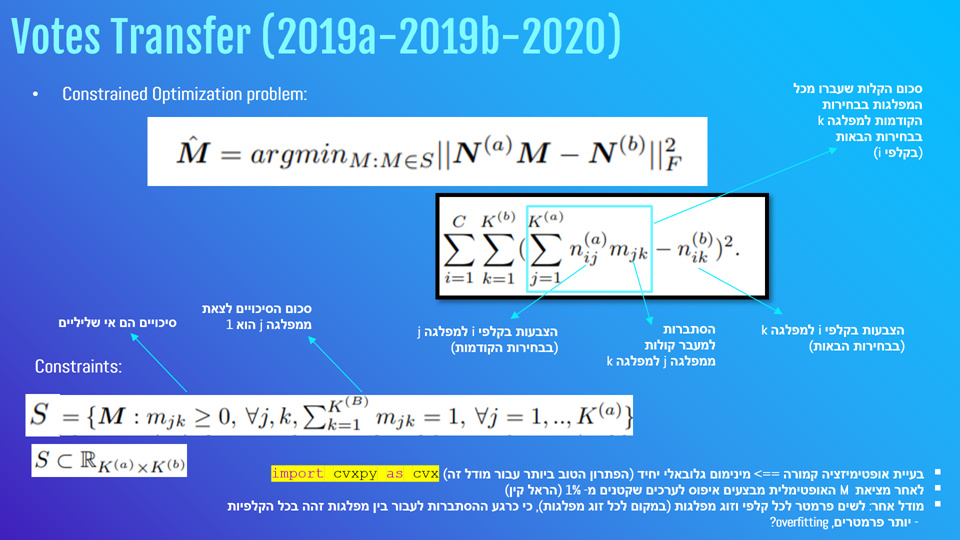

  <div dir="rtl">

נשים לב שמודל זה מניח שההסתברות לעבור ממפלגה מסויימת בבחירות קודמות למפלגה אחרת בבחירות הבאות זהה בכל הקלפיות.

הנחה זו עוזרת לנו מהבחינה שיש לנו רק k(A)xK(B) פרמטרים, במקום CxK(A)xK(B), כאשר C מייצג את מספר הקלפיות ו-K את מספר המפלגות במערכת בחירות מסויימת.

היינו רוצים להשתמש במודל השני משום שהוא הכי מדויק, אבל מצד שני למודל כזה יש הרבה פרמטרים (ואולי יותר מדי כך שמערכת המשוואות תהיה בלתי פתירה גם באופן מקורב).
לכן ישנם מודלים אחרים, למשל מודל שמניח שההסתברות לעבור ממפלגה למפלגה אחרת קבוע לפי האשכול הכלכלי-חברתי של הקלפיות, וכו'.

</div>

## **Imports**

In [1]:
import pandas as pd  
import numpy as np
import cvxpy as cvx
import plotly.graph_objs as go


## **Load Data**

In [2]:
url = "https://raw.githubusercontent.com/OdedMous/ElectionsDataAnalysis/main/data/votes%20per%20ballot%202019a.csv"
df_ballots_2019a_raw = pd.read_csv(url, encoding = 'iso-8859-8', index_col='שם ישוב')

In [3]:
url = "https://raw.githubusercontent.com/OdedMous/ElectionsDataAnalysis/main/data/votes%20per%20ballot%202019b.csv"
df_ballots_2019b_raw = pd.read_csv(url, encoding = 'iso-8859-8', index_col='שם ישוב')
df_ballots_2019b_raw = df_ballots_2019b_raw.rename(columns={'קלפי': 'מספר קלפי'})

In [4]:
url = "https://raw.githubusercontent.com/OdedMous/ElectionsDataAnalysis/main/data/votes%20per%20ballot%202020.csv"
df_ballots_2020_raw = pd.read_csv(url, encoding = 'iso-8859-8', index_col='שם ישוב')
df_ballots_2020_raw = df_ballots_2020_raw.rename(columns={'קלפי': 'מספר קלפי'})

In [5]:
url = "https://raw.githubusercontent.com/OdedMous/ElectionsDataAnalysis/main/data/votes%20per%20ballot%202021.csv"
df_ballots_2021_raw = pd.read_csv(url, encoding = 'iso-8859-8', index_col='שם ישוב')
df_ballots_2021_raw = df_ballots_2021_raw.rename(columns={'קלפי': 'מספר קלפי'})

In [6]:
parties_dict_2019a ={'אמת' : "עבודה", 'ג' : "יהדות התורה", 'דעם'  : "רעם בלד", 'ום'  : "חדש תעל", 'טב'  : "איחוד מפלגות הימין",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד", 'מרצ'  : "מרצ", 'פה'  : "כחול לבן", 'שס'  : "שס",  'כ'  : "כולנו",  'נ'  : "ימין חדש",  'ז'  : "זהות",  'נר'  : "גשר"}

parties_dict_2019b ={'אמת' : "עבודה גשר", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת", 'טב'  : "ימינה", 'כף'  : "עוצמה יהודית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד", 'מרצ'  : "המחנה הדמוקרטי", 'פה'  : "כחול לבן", 'שס'  : "שס"}

parties_dict_2020 ={'אמת' : "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת", 'טב'  : "ימינה", 'נץ'  : "עוצמה יהודית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

parties_dict_2021 ={'אמת' : "עבודה", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",
                    'כן'  : "כחול לבן", 'שס'  : "שס", "פה": "יש עתיד", "ט": "הציונות הדתית", "ת":"תקווה חדשה", "מרצ":"מרצ", "עם": "רעם"}

## **Votes Transfer Calculation**

In [7]:
def adapt_df(df, parties, include_no_vote=False, ballot_number_field_name=None):
  
    df['ballot_id'] = df['סמל ישוב'].astype(str) + '__' + df[ballot_number_field_name].astype(str)
    df = df.set_index('ballot_id')
    eligible_voters = df['בזב']
    total_voters = df['מצביעים']
    df = df[parties]
    # df = df.reindex(df.columns, axis=1)
    if include_no_vote:
        df['לא הצביע'] = eligible_voters - total_voters
    return df

def solve_transfer_coefficients(x_data, y_data, verbose):

    M = cvx.Variable([x_data.shape[1], y_data.shape[1]])
    constraints = [0 <= M, M <= 1, cvx.sum(M, axis=1) == 1]
    objective = cvx.Minimize(cvx.norm((x_data @ M) - y_data, 'fro'))
    prob = cvx.Problem(objective, constraints)
    prob.solve(solver='SCS', verbose=True)
    M = M.value

    if verbose:
        print(M.min())  # should be close to 0
        print(M.max())  # should be close to 1
        print(M.sum(axis=1).min())  # should be close to 1
        print(M.sum(axis=1).max())  # should be close to 1
    return M

In [8]:
parties21 = "מחל טב נר ז ל כ שס ג פה אמת מרצ ום דעם".split()
parties22 = " מחל טב ל שס ג פה אמת מרצ ודעם".split()
parties23 = "מחל טב ל שס ג פה אמת ודעם".split()
parties24 = "ט ב מחל ת ל שס ג כן פה אמת מרצ ודעם עם".split()

b21 = adapt_df(df_ballots_2019a_raw, parties21, include_no_vote=True, ballot_number_field_name='מספר קלפי')
b22 = adapt_df(df_ballots_2019b_raw, parties22, include_no_vote=True, ballot_number_field_name='מספר קלפי')
b23 = adapt_df(df_ballots_2020_raw, parties23, include_no_vote=True, ballot_number_field_name='מספר קלפי')
b24 = adapt_df(df_ballots_2021_raw, parties24, include_no_vote=True, ballot_number_field_name='מספר קלפי')

u = pd.merge(b21, b22, how='inner', left_index=True, right_index=True)
u = pd.merge(u, b23, how='inner', left_index=True, right_index=True)
u = pd.merge(u, b24, how='inner', left_index=True, right_index=True)

v21 = b21.loc[u.index].values
v22 = b22.loc[u.index].values
v23 = b23.loc[u.index].values
v24 = b24.loc[u.index].values

# Use convex solver with constraints
M = solve_transfer_coefficients(v21, v22, True).T
M_2 = solve_transfer_coefficients(v22, v23, True).T
M_3 = solve_transfer_coefficients(v23, v24, True).T

M[M<0.01] = 0.
M_2[M_2<0.01] = 0.
M_3[M_3<0.01] = 0.

vote_movements = M * b21.sum(axis=0).values
vote_movements_2 = M_2 * b22.sum(axis=0).values
vote_movements_3 = M_3 * b23.sum(axis=0).values

----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 416381
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 141, constraints m = 36685
Cones:	primal zero / dual free vars: 14
	linear vars: 280
	soc vars: 36391, soc blks: 1
Setup time: 1.10e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.04e+20  8.89e+22  1.00e+00 -3.21e+23  2.94e+24  2.87e+24  2.68e-02 
   100| 1.27e-04  9.73e-01  4.88e-04  2.62e+03  2.62e+03  1.06e-13  8.91e-01 
   200| 8.74e-06  3.64e-02  1.29e-06  2.62e+03  2.62e+03 

In [33]:
def sankey(vote_movements,vote_movements_2, vote_movements_3, parties21, parties22, parties23, parties24):

    # number of parties in the different elections
    n21 = len(parties21)  
    n22 = len(parties22)
    n23 = len(parties23)
    n24 = len(parties24)
  
    source, target = np.meshgrid(np.arange(0, n21),
                                 np.arange(n21, n21 + n22))
    
    source_2, target_2 = np.meshgrid(np.arange(n21, n21 + n22),
                                     np.arange(n21 + n22, n21 + n22 + n23))
    
    source_3, target_3 = np.meshgrid(np.arange(n21 + n22, n21 + n22 + n23),
                                     np.arange(n21 + n22 + n23, n21 + n22 + n23 + n24))

    source = list(source.flatten()) + list(source_2.flatten()) + list(source_3.flatten())
    target = list(target.flatten()) + list(target_2.flatten()) + list(target_3.flatten())
    

    # Parties reverse names
    parties21_rev = [parties_dict_2019a[party][::-1] if party in parties_dict_2019a  else 'לא הצביעו'[::-1] for party in parties21]
    parties22_rev = [parties_dict_2019b[party][::-1] if party in parties_dict_2019b  else 'לא הצביעו'[::-1] for party in parties22]
    parties23_rev = [parties_dict_2020[party][::-1] if party in parties_dict_2020  else 'לא הצביעו'[::-1] for party in parties23]
    parties24_rev = [parties_dict_2021[party][::-1] if party in parties_dict_2021  else 'לא הצביעו'[::-1] for party in parties24]

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=40,
            label=list(parties21_rev) + list(parties22_rev) + list(parties23_rev) + list(parties24_rev)
        ),
        link=dict(
            source=source,  # indices correspond to labels
            target=target,
            value=list(vote_movements.flatten()) + list(vote_movements_2.flatten()) + list(vote_movements_3.flatten()),
            hovertemplate='%{value} voters passed from ' + '"%{source.label}"<br />'+'to "%{target.label}"<br />' +'<extra></extra>' 
        ))])

    fig.update_layout(title_text="""2019a                                 2019b                                 2020                            2021""",
                      font_size=16) 
    fig.show()
    return fig

In [34]:
fig = sankey(vote_movements, vote_movements_2, vote_movements_3,   b21.columns.values, b22.columns.values,  b23.columns.values, b24.columns.values)
fig.write_html("/sankey_plot.html")